In [1]:
import os
import sys
from collections import OrderedDict

from math import floor, log10, pi, ceil
from os.path import splitext

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from utility.file_operations import remove_config_path

In [2]:
config_col = 'config'
best_rate_col = 'best_rate'
best_rate_error_col = 'best_rate_error'
min_rate_col = 'min_rate'
max_rate_col = 'max_rate'
model_col = 'model_desc'
normalized_error_col = 'normalized_error'
merge_add = "_merge"
excluded_models = ['Idealized perfectly absorbing']
non_parameter_models = ['Idealized perfectly absorbing', 'Perfectly absorbing']
relative_performance_col = 'relative_performance'
particle_name_col = 'particle_name'
cell_line_col = 'cell_line_name'
max_detectable_rate_col = 'max_detectable_rate'
radius_col = 'radius_in_m'
results_file = None
# name_to_display_name = {'Cell carrying capacity': 'CCC',
#                          'Linear': 'LIN',
#                          'Perfectly absorbing': 'PFA',
#                          'Surface flux': 'SFL',
#                          'Surface flux and cell carrying capacity': 'ALL'}
# name_to_display_name = OrderedDict({'Perfectly absorbing': 'Perfectly absorbing',
#                                     'Cell carrying capacity': 'Cell carrying capacity',
#                                     'Surface flux and cell carrying capacity': 'Full (surface flux+cell capacity)',
#                                     'Linear': 'Linear',
#                                     'Surface flux': 'Surface flux'})
perfectly_absorbing = 'Perfectly absorbing'
cell_carrying_cap = 'Cell carrying capacity'

name_to_display_name = OrderedDict([('Perfectly absorbing', perfectly_absorbing),
                                    ('Cell carrying capacity', cell_carrying_cap),
                                    ('Surface flux and cell carrying capacity', 'Full (surface flux+cell capacity)'),
                                    ('Linear', 'Linear'),
                                    ('Surface flux', 'Surface flux')])

colors = ['#9467bd',  # purple,
          '#1f77b4',  # blue
          '#2ca02c',  # green
          '#d62728',  # red
          '#ff7f0e',  # orange
          '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']

f_test_model_and_params = ('Surface flux and cell carrying capacity', 3)
to_test_models_and_params = {'Perfectly absorbing': 0, 'Linear': 1, 'Surface flux': 2, 'Cell carrying capacity': 2}
f_test_col = 'f_test'
param_col = 'param'
exp_name_col = 'name'

naming_dict = OrderedDict([
    ('a', 1),
    ('b', 2)
])

mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['axes.linewidth'] = 2.0
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 12}

mpl.rc('font', **font)

def _get_num_timepoints(config_name):
    if 'static_PMA_' in config_name or 'slosher_PMA_' in config_name:
        return 3
    if 'fuchs_' in config_name:
        return 4
    if 'david_' in config_name:
        return 5
    if 'leo_' in config_name:
        return 7
    raise ValueError('Unknown config')


def round_to_significant_figures(val, figs=2):
    return round(val, figs - int(floor(log10(abs(val)))) - 1)


def best_model_counts(df: pd.DataFrame):
    rdf = df.copy()
    # Error precision is high, filter to two significant figures
    rdf[best_rate_error_col] = rdf[best_rate_error_col].apply(lambda x: round_to_significant_figures(x, figs=2))
    # rdf = df.round({best_rate_error_col: 2})

    # group by config and find the smallest error
    bdf = rdf.groupby(by=[config_col], as_index=False).agg({best_rate_error_col: 'min'})

    # merge with results and only keep rows that have the best best error for each config
    bdf = rdf.merge(bdf, left_on=[config_col, best_rate_error_col], right_on=[config_col, best_rate_error_col],
                    suffixes=('', merge_add))

    # aggregate report of the best model for each config
    winners_for_config = bdf.groupby(by=[config_col, best_rate_error_col]).agg(
        {model_col: lambda c: c.str.cat(sep=', ')})
    winners_for_config.to_csv('{}_winners_each_config.csv'.format(splitext(results_file)[0]))

    # aggregate report of how many "wins" for each model
    model_wins = bdf.groupby(by=[model_col]).agg({config_col: 'count'})
    model_wins.to_csv('{}_total_wins.csv'.format(splitext(results_file)[0]))

    return model_wins


def model_performance_all_configs(df: pd.DataFrame):
    best_rate_all = best_rate_error_col + merge_add

    # group by config and find the smallest error
    bdf = df.groupby(by=[config_col], as_index=False).agg({best_rate_error_col: 'min'})
    pdf = df.merge(bdf, left_on=config_col, right_on=config_col, suffixes=('', merge_add))

    aggs = {}
    for diff in [0, .01, 0.05, 0.1, 0.15]:
        perf_col = 'relative error difference <= {}'.format(diff)
        perf_config_col = 'configs where relative error difference >= {}'.format(diff)
        pdf[perf_col] = abs((pdf[best_rate_all] - pdf[best_rate_error_col]) / pdf[best_rate_all]) <= diff
        pdf[perf_config_col] = pdf[config_col].where(~pdf[perf_col], '')
        aggs[perf_col] = 'sum'
        aggs[perf_config_col] = lambda c: c.str.cat(sep=' ')

    each_model_performance = pdf.groupby(by=[model_col]).agg(aggs)
    each_model_performance.to_csv('{}_model_performance.csv'.format(splitext(results_file)[0]))
    return pdf


def relative_performance(df: pd.DataFrame):
    best_rate_all = best_rate_error_col + merge_add

    # group by config and find the SMALLEST error
    bdf = df.groupby(by=[config_col], as_index=False).agg({best_rate_error_col: 'min'})

    # join with rest of data
    pdf = df.merge(bdf, left_on=config_col, right_on=config_col, suffixes=('', merge_add))

    # find error normalized to best error (ie, best performance = 1, worst performance = 0)
    pdf[relative_performance_col] = (pdf[best_rate_all] / pdf[best_rate_error_col])
    pdf.to_csv('{}_relative_performance.csv'.format(splitext(results_file)[0]))
    return pdf


def do_radar_plot(df: pd.DataFrame, ax, plot_col):
    # We are going to plot the values from the data Frame
    # But we need to repeat the first value to close the circular graph:
    values = list(df[plot_col].values)
    values += values[:1]

    # values=df.loc[0].drop('group').values.flatten().tolist()
    # values += values[:1]
    # values

    # Angle of each plotted value is total
    full_circle = pi * 2
    N = len(values) - 1
    angles = [(n / N) * full_circle for n in range(N)]
    angles += angles[:1]

    # Draw ylabels
    # ax.set_yscale('log')
    ax.set_yticks([])
    ax.set_yticklabels([])
    # ax.set_ylim(0, 1.2)

    ax.set_xticks([])
    ax.set_xticklabels([])
    # ax.set_xticks(angles)
    # ax.set_xticklabels(df[model_col].values)


    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)


def do_windrose_plot(df: pd.DataFrame, ax, plot_col, used_colors=colors):
    values = list(df[plot_col].values)

    # Angle of each plotted value is total
    full_plot = pi * 2
    N = len(values)

    angles = [(n / N) * full_plot for n in range(N)]

    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_ylim(0, 1.1)

    ax.set_xticks([])
    ax.set_xticklabels([])
    # ax.set_xticks(angles)
    # ax.set_xticklabels(df[model_col].values)

    # Plot data
    ax.bar(angles, values, width=5 / 8 * 1 / N * full_plot, bottom=0.0, color=used_colors, edgecolor='none')
    ax.spines['polar'].set_visible(False)
    ax.set_facecolor((0.9, 0.9, 0.9))
    # ax.plot(angles, values, linewidth=1, linestyle='solid')

    # Fill area
    # ax.fill(angles, values, 'b', alpha=0.1)


def graph_model_performance(df: pd.DataFrame, rows, cols,
                            experiment_desc_col=config_col,
                            category_col=model_col,
                            performance_col=relative_performance_col,
                            used_colors=colors):
    #fig = plt.figure(figsize=(7.3, 1.4 * (rows + 1)), facecolor=(0.75, 0.75, 0.75))
    fig = plt.figure(figsize=(7.3, 1.4 * (rows + 1)))

    # gs = gridspec.GridSpec(rows, cols, figure=fig)

    # fig, axes = plt.subplots(rows, cols,
    #                          subplot_kw={'projection': 'polar'},
    #                          figsize=(7.3, 1.4 * (rows + 1)))

    experiments = df.groupby(by=experiment_desc_col)
    # gkeys = experiments.experiments.keys()
    last_desc_pos = 0
    axes = []
    # axes = axes.flatten()
    for i, experiment in enumerate(experiments):
        # ax = axes[i]
        ax = plt.subplot2grid((rows + 2, cols), (int(i / cols), i % cols), projection='polar')
        axes.append(ax)
        # ax = gs[i / rows, i % cols]
        gdf = experiment[1]
        sort_order = lambda name: list(name_to_display_name.values()).index(name)
        gdf['sort'] = gdf[category_col].map(sort_order)
        gdf = gdf.sort_values(by='sort')
        do_windrose_plot(gdf, ax, performance_col, used_colors)
        fig.text(-0.1, 1.1, '{})'.format(chr(i + 97)), verticalalignment='top', horizontalalignment='left',
                 fontweight='bold', transform=ax.transAxes)
        # desc_pos = last_desc_pos*-1 + 1
        # text = os.path.split(experiment[0])[1][3:-4]
        # plt.text(0.5, desc_pos, text, transform=ax.transAxes, fontsize=10, ha='center')
        # last_desc_pos = desc_pos
        # pos = ax.get_position()
        # rect = mpatches.Rectangle((pos.x0, pos.y0), pos.width, pos.height, fill=False, transform=fig.transFigure)
        # fig.patches.extend([rect])

        #plt.show(block=False)
    max_i = i
    # ax.position
    # p = mpatches.Rectangle((0,0), 0.5, 0.5, fill=False,
    #                        transform= fig.transFigure)
    # fig.patches.extend([p])
    #

    agg_ax = plt.subplot2grid((rows+2, cols), (rows, 1), colspan=cols-2, rowspan=2)
    graph_combined_model_performance(agg_ax, df)

    patches = []
    labels = gdf[category_col].values

    for i, _ in enumerate(labels):
        patch = mpatches.Patch(color=used_colors[i], label='')
        patches.append(patch)

    fig.legend(handles=list(patches), labels=list(labels), loc='lower center', ncol=2)
    # fig.subplots_adjust(bottom=0.2, left=0.01, right=.99, top=.99)
    # plt.tight_layout()
#     fig.subplots_adjust(bottom=0.1)
    bbox = agg_ax.get_position()
    fig.text(-0.1, 1, '{})'.format(chr(max_i+1 + 97)), fontweight='bold',
             verticalalignment='center', horizontalalignment='left', transform=agg_ax.transAxes)
    # fig.text(bbox.x0 - bbox.width * 0.15, bbox.y0 + bbox.height*0.8, '{})'.format(chr(i+1 + 97)), verticalalignment='center', horizontalalignment='left',
    #          fontweight='bold')




def graph_combined_model_performance(ax: plt.Axes, df: pd.DataFrame, category_col=model_col):
    # rdf = relative_performance(df)
    gdf = df.groupby(by=category_col)

    results = gdf.agg('sum')

    sort_order = lambda name: list(name_to_display_name.values()).index(name)
    results['sort'] = results.index.map(sort_order)
    results = results.sort_values(by='sort')

    xs = range(results.shape[0])

    ax.bar(xs, results[relative_performance_col], color=colors, edgecolor='none')

    ax.set_xlim((-0.5, len(xs)))
    ax.set_ylim((0, ax.get_ylim()[1]*1.1))
    ax.set_xticks([], [])
    ax.set_xlabel('')
    ax.set_ylabel('Combined\n performance')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # ax.bar(angles, values, width=5 / 8 * 1 / N * full_plot, bottom=0.0, color=used_colors, edgecolor='none')


def df_to_diameters_in_nms(df: pd.DataFrame):
    diameters_in_nms = df[radius_col].values * 2 / 1e-9
    return ('Diameter (nm)', diameters_in_nms)


def df_to_fuchs_concs(df: pd.DataFrame):
    def config_to_conc(config):
        if config.endswith('_1.ini'):
            return 0.0125
        elif config.endswith('_2.ini'):
            return 0.05
        else:
            return 0.2

    concs = df[config_col].map(config_to_conc)
    return ('Concentration($\mu$m)', concs)


def plot_rate_and_xvals(particle_type_groups, get_xvals=df_to_diameters_in_nms, global_kwargs={}):
    plt.figure(figsize=(7.3, 6.3))
    ax = plt.gca()
    ax.set_yscale('log')
    keys = sorted(particle_type_groups.keys(), reverse=True)
    for gname in keys:
        sdf, kwargs = particle_type_groups[gname]
        xlabel, xvals = get_xvals(sdf)

        # in rare cases best rate could be lower than min/max rate, due to how we calculate them. find the actual min and max rate
        min_rates = sdf[[min_rate_col, best_rate_col, max_rate_col]].min(axis=1)
        max_rates = sdf[[min_rate_col, best_rate_col, max_rate_col]].max(axis=1)

        # best rate = best rate col, unless it's greater than the max detectable rate
        best_rates = sdf[[best_rate_col, max_detectable_rate_col]].min(axis=1)
        lolims = (sdf[best_rate_col] >= sdf[max_detectable_rate_col])
        lower_errors = (sdf[best_rate_col] - min_rates)
        upper_errors = (max_rates - sdf[best_rate_col])
        upper_errors = (~lolims * upper_errors) + (
            1.1 * lolims * best_rates)  # set errors to 0.1 wherever we have no upper bound
        all_kwargs = global_kwargs.copy()
        all_kwargs.update(kwargs)
        plt.errorbar(xvals, best_rates,
                     lolims=lolims, yerr=[lower_errors, upper_errors],
                     label=gname, marker='o',
                     **all_kwargs)
    ax.legend(fancybox=True, framealpha=0.5, fontsize=10)
    plt.xlabel(xlabel)
    plt.ylabel('Association Rate (s$^{-1}$)')

    plt.tight_layout()
    plt.show(block=False)


def _calc_f_test(ser: pd.Series):
    rss1 = ser[best_rate_error_col]
    # this is MSE instead of RSS, but since n term falls out in division, f test is equivalent
    rss2 = ser[best_rate_error_col + merge_add]
    p2 = f_test_model_and_params[1]
    p1 = ser[param_col]
    n = _get_num_timepoints(ser[config_col])
    if n - p2 == 0:
        return float('NaN')
    f_statistic = ((rss1 - rss2) / (p2 - p1)) / (rss2 / (n - p2))
    return f_statistic


def f_test(df: pd.DataFrame):
    only_top_model = df[df[model_col] == f_test_model_and_params[0]]
    jdf = df.merge(only_top_model, on=config_col, suffixes=('', merge_add))
    jdf = jdf[~(jdf[model_col] == f_test_model_and_params[0])]
    jdf[param_col] = jdf[model_col].replace(to_test_models_and_params)
    jdf[f_test_col] = jdf.apply(_calc_f_test, axis=1)
    jdf = jdf.sort_values(by=f_test_col, ascending=False)
    return jdf
    # joined[param_col] =


def parameter_consistency(df: pd.DataFrame, eldf: pd.DataFrame):
    jdf = df.merge(eldf, on=config_col, suffixes=('', merge_add))
    jdf = jdf[~jdf[model_col].isin(non_parameter_models)]
    jdf = jdf.groupby(by=[exp_name_col, model_col])
    jdf = jdf.agg(["std"]).reset_index()
    jdf = pd.DataFrame({exp_name_col: jdf[exp_name_col],
                        model_col: jdf[model_col],
                        best_rate_col: jdf[best_rate_col]['std']})

    return jdf
    # min_rates = jdf.groupby(exp_name_col).agg('min').reset_index()
    # jdf = jdf.merge(min_rates, on=exp_name_col, suffixes=('', merge_add))
    # jdf = jdf[jdf[best_rate_col] == jdf[best_rate_col+merge_add]]
    # return jdf


def graph_normalized_parameter_consistency(pcdf: pd.DataFrame):
    maxdf = pcdf.groupby(exp_name_col).agg("max").reset_index()
    df = pcdf.merge(maxdf, on=exp_name_col, suffixes=('', merge_add))
    # df[best_rate_col] = df[best_rate_col] / df[best_rate_col+merge_add]
    gdf = df.groupby(model_col)

    for name, grouped in gdf:
        grouped = grouped.sort_values(by=exp_name_col)
        xs = range(0, grouped.shape[0])
        ys = grouped[best_rate_col].values
        plt.plot(xs, ys, label=name)
    plt.ylim((0, 1e-7))
    plt.xticks(xs, grouped[exp_name_col], rotation=45)

    plt.legend(loc='best', prop={'size': 8})
    plt.tight_layout()


def get_combined_filtered_results(results: pd.DataFrame,
                                  config_details: pd.DataFrame,
                                  max_rates: pd.DataFrame):
    # reset config names to only contain the filename (in case runs on different systems)
    for df in [results, config_details, max_rates]:
        remove_config_path(df)

    config_info = config_details.groupby(by=config_col,
                                         as_index=False).first()  # only care about details, not time info

    max_rates = max_rates.rename(columns={best_rate_col: max_detectable_rate_col})
    cdf = results.merge(config_info, on=config_col, suffixes=('', '_details'))
    cdf = cdf.merge(max_rates, on=config_col, how='left', suffixes=('', '_max_rates'))
    cdf[max_detectable_rate_col] = cdf[max_detectable_rate_col].fillna(
        9999)  # if there's no info in the max rates col, the max rate is infinite
    cdf = cdf[~cdf[model_col].isin(excluded_models)]
    cdf[model_col] = cdf[model_col].map(name_to_display_name)
    return cdf


def plot_relative_model_performance(df: pd.DataFrame):
    rdf_all = relative_performance(df)
    graph_model_performance(rdf_all, 5, 5, performance_col=relative_performance_col)
    plt.savefig('{}_model_performance_all.png'.format(splitext(results_file)[0]),
                facecolor=plt.gcf().get_facecolor())


def plot_all_model_vs_experimental(df: pd.DataFrame, rows, cols):
    fig, axes = plt.subplots(rows, cols,
                             figsize=(10.8, 1.2 * (rows + 2)))
    axes = axes.flatten()

    model_color = '#1f77b4'

    agdf = df.groupby(by=[config_col])
    for i, (gname, gdf) in enumerate(agdf):
        gdf = gdf.sort_values(by='time_in_mins')
        times = gdf['time_in_mins'].values / 60
        actual = gdf['actual_values'].values
        std_dev = gdf['actual_std_dev'].values
        model_best = gdf['model_best_rate_values'].values
        model_min = gdf['model_min_rate_values'].values
        model_max = gdf['model_max_rate_values'].values
#         axes[i].linewidth = 3.0
        axes[i].errorbar(times, actual, yerr=std_dev, color= '#FF4500')  # '#8c564b'
        # axes[i].plot(times, actual)
        axes[i].plot(times, model_best, color=model_color)
        axes[i].plot(times, model_min, linestyle='--', color=model_color)
        axes[i].plot(times, model_max, linestyle='--', color=model_color)
        axes[i].set_xlim([0, 25])
        ymax = axes[i].get_ylim()[1]
        if ymax < 0.5:
            ymax = ceil(ymax * 10) / 10
        else:
            ymax = ceil(ymax)
        axes[i].set_ylim([0, ymax])
        axes[i].set_xticks([])
        if i >= rows * (cols - 1):
            axes[i].set_xticks([0, 25])
            # axes[i].set_xlabel('Time (h)')
        axes[i].set_yticks([0, ymax])
        axes[i].tick_params(axis='both', which='both', length=0)
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        letter_label = '{})'.format(chr(i + 97))
        axes[i].text(-0.23, 1.2, letter_label, verticalalignment='center', horizontalalignment='center',
                     fontweight='bold', transform=axes[i].transAxes)
        print('{} {}'.format(letter_label, gname), end=' ')
    print('')
    exp_patch = mpatches.Patch(color='#FF4500', label='')
    model_patch = mpatches.Patch(color=model_color, label='')
    plt.tight_layout()
    fig.legend(handles=[exp_patch, model_patch], labels=['Actual', 'Model'], loc='lower center', ncol=2)
    plt.subplots_adjust(bottom=0.1)

In [41]:
results_file = "/media/sf_Dropbox/scienceData/fcs data/output/run_2018_08_29/combined.csv"
results = remove_config_path(pd.read_csv(results_file))
config_details = remove_config_path(pd.read_csv("/media/sf_Dropbox/scienceData/fcs data/output/run_2018_08_29/all_config_details.csv"))
model_and_actual = remove_config_path(pd.read_csv("/media/sf_Dropbox/scienceData/fcs data/output/run_2018_08_29/combined_model_and_actual.csv"))
max_rates = remove_config_path(pd.read_csv("/media/sf_Dropbox/scienceData/fcs data/output/max_rate.csv"))

a) david_HA-PEG-MPN_BT474.ini b) david_HA-PEG-MPN_MDA-MB-231.ini c) leo_1032nm_capsule_hela.ini d) leo_1032nm_capsule_raw.ini e) leo_1032nm_capsule_thp1.ini f) leo_150nm_coreshell_hela.ini g) leo_150nm_coreshell_raw.ini h) leo_150nm_coreshell_thp1.ini i) leo_214nm_capsule_hela.ini j) leo_214nm_capsule_raw.ini k) leo_214nm_capsule_thp1.ini l) leo_282nm_coreshell_hela.ini m) leo_282nm_coreshell_raw.ini n) leo_282nm_coreshell_thp1.ini o) leo_480nm_capsule_hela.ini p) leo_480nm_capsule_raw.ini q) leo_480nm_capsule_thp1.ini r) leo_633nm_coreshell_hela.ini s) leo_633nm_coreshell_raw.ini t) leo_633nm_coreshell_thp1.ini u) leo_95nm_coreshell_raw.ini v) slosher_PMA_capsule.ini w) slosher_PMA_coreshell.ini x) static_PMA_capsule.ini y) static_PMA_coreshell.ini 


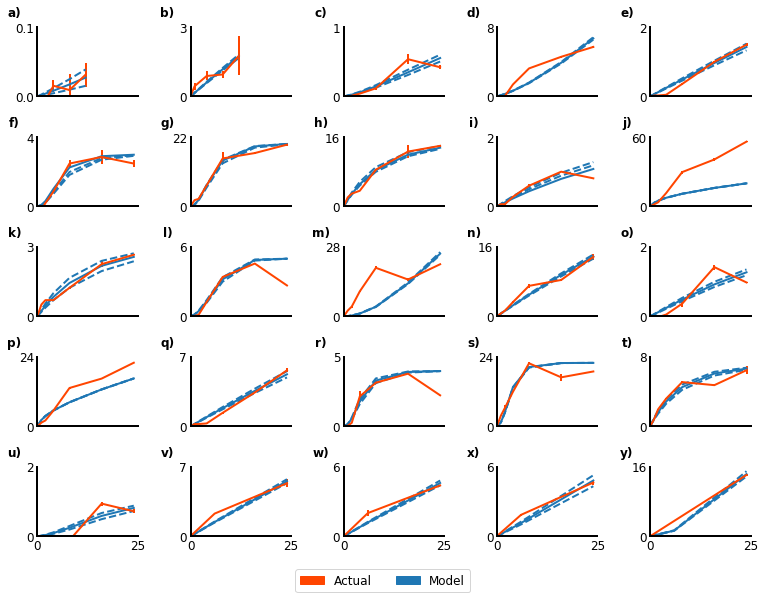

In [42]:
plot_all_model_vs_experimental(model_and_actual, 5, 5)
plt.savefig('{}_model_vs_actual.png'.format(splitext(results_file)[0]),
            facecolor=plt.gcf().get_facecolor())

/home/x/.local/lib/python3.5/site-packages/ipykernel_launcher.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


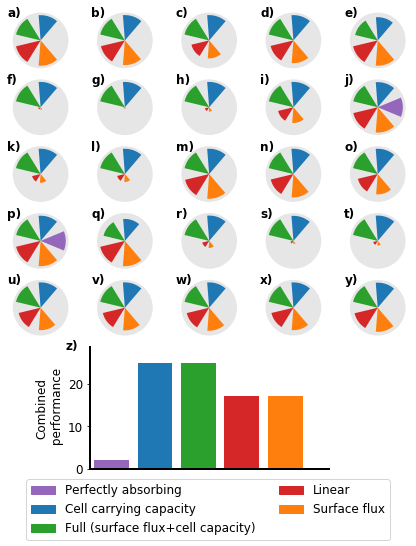

In [43]:
full_results = get_combined_filtered_results(results, config_details, max_rates)
no_fuchs = full_results[~(full_results[config_col].str.contains('fuchs_'))]
only_fuchs = full_results[(full_results[config_col].str.contains('fuchs_'))]


plot_relative_model_performance(no_fuchs)

In [44]:
def label_and_spines(ax, top_left_label):
    plt.text(-0.2, 1.1, top_left_label, horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes, fontsize=14, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

def plot_size_vs_rate(df: pd.DataFrame, label, **kwargs):
    plt.gca().set_prop_cycle(None)

    label_and_spines(plt.gca(), label)
    sdf = df.sort_values(by=radius_col)
    plt.yscale('log')
        
    xs = sdf[radius_col].values * 2 / 1e-9
    # in rare cases best rate could be lower than min/max rate, due to how we calculate them. find the actual min and max rate
    min_rates = sdf[[min_rate_col, best_rate_col, max_rate_col]].min(axis=1)
    max_rates = sdf[[min_rate_col, best_rate_col, max_rate_col]].max(axis=1)

    # best rate = best rate col, unless it's greater than the max detectable rate
    best_rates = sdf[[best_rate_col, max_detectable_rate_col]].min(axis=1)
    lolims = (sdf[best_rate_col] >= sdf[max_detectable_rate_col])
    lower_errors = (sdf[best_rate_col] - min_rates)
    upper_errors = (max_rates - sdf[best_rate_col])
    upper_errors = (~lolims * upper_errors) + (
        5.0 * lolims * best_rates)  # set errors to 0.1 wherever we have no upper bound (just sets height of arrow)
    plt.errorbar(xs, best_rates,
                 lolims=lolims, yerr=[lower_errors, upper_errors],
                 **kwargs)
    plt.ylim([5e-12, 10e-5])
    plt.xlim([0, 1400])
    plt.ylabel('Association rate (s$^{-1}$)')
    plt.xlabel('Diameter (nm)')

In [45]:
ccc_df = no_fuchs[no_fuchs[model_col] == cell_carrying_cap]
hela_coreshells = ccc_df[(ccc_df[cell_line_col] == 'HeLa') & (ccc_df[particle_name_col].str.contains('Core/'))]
hela_capsules = ccc_df[(ccc_df[cell_line_col] == 'HeLa') & (ccc_df[particle_name_col].str.contains('Capsule'))]

thp1_coreshells = ccc_df[(ccc_df[cell_line_col] == 'THP-1') & (ccc_df[particle_name_col].str.contains('Core/'))]
thp1_capsules = ccc_df[(ccc_df[cell_line_col] == 'THP-1') & (ccc_df[particle_name_col].str.contains('Capsule'))]

raw_coreshells = ccc_df[(ccc_df[cell_line_col] == 'RAW') & (ccc_df[particle_name_col].str.contains('Core/'))]
raw_capsules = ccc_df[(ccc_df[cell_line_col] == 'RAW') & (ccc_df[particle_name_col].str.contains('Capsule'))]

target_ha_peg_mpns = ccc_df[(ccc_df[cell_line_col] == 'MDA-MB-231 (target)')]
nontarget_ha_peg_mpns = ccc_df[(ccc_df[cell_line_col] == 'BT-474 (non-target)')]


fibr_static_capsules = ccc_df[(ccc_df[cell_line_col] == 'NIH3T3 Fibroblast') & 
                             (ccc_df[particle_name_col] == 'PMA Capsules (Static)')]
fibr_well_mixed_capsules = ccc_df[(ccc_df[cell_line_col] == 'NIH3T3 Fibroblast') & 
                                 (ccc_df[particle_name_col] == 'PMA Capsules (Slosher)')]
fibr_static_coreshells = ccc_df[(ccc_df[cell_line_col] == 'NIH3T3 Fibroblast') & 
                               (ccc_df[particle_name_col] == 'PMA Core-shell (Static)')]
fibr_well_mixed_coreshells = ccc_df[(ccc_df[cell_line_col] == 'NIH3T3 Fibroblast') & 
                                   (ccc_df[particle_name_col] == 'PMA Core-shell (Slosher)')]

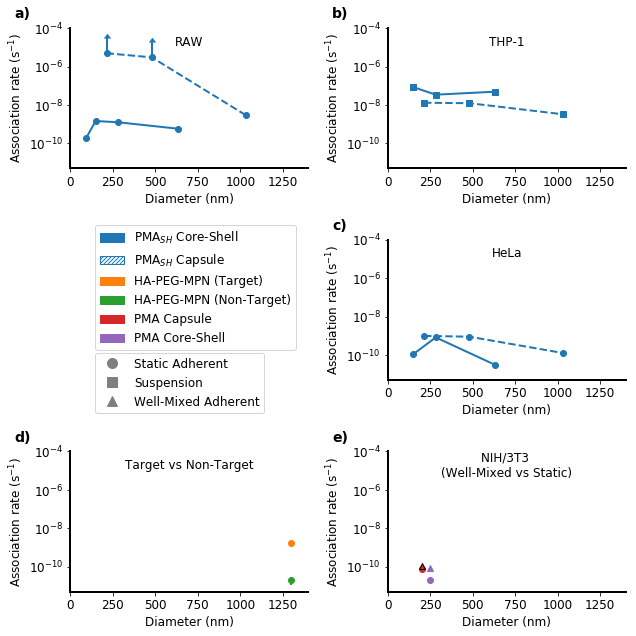

In [51]:
fig = plt.figure(figsize=(9, 9))
r = 3
c = 2

sam = 'o'
spm = 's'
wmm = '^'


plt.subplot(r,c,1)
plot_size_vs_rate(raw_coreshells, 'a)', marker=sam)
plot_size_vs_rate(raw_capsules, '',  linestyle='dashed', marker=sam)
plt.text(0.5, 0.9, 'RAW', horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12)

plt.subplot(r,c,2)
plot_size_vs_rate(thp1_coreshells, 'b)', marker=spm)
plot_size_vs_rate(thp1_capsules, '',  linestyle='dashed', marker=spm)
plt.text(0.5, 0.9, 'THP-1', horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12)

plt.subplot(r,c,4)
plot_size_vs_rate(hela_coreshells, 'c)', marker=sam)
plot_size_vs_rate(hela_capsules, '',  linestyle='dashed', marker=sam)
plt.text(0.5, 0.9, 'HeLa', horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12)

plt.subplot(r,c,5)
plot_size_vs_rate(target_ha_peg_mpns, 'd)', color='#ff7f0e', marker=sam)
plot_size_vs_rate(nontarget_ha_peg_mpns, '',  color='#2ca02c', marker=sam)
plt.text(0.5, 0.9, 'Target vs Non-Target', horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12)


plt.subplot(r,c,6)
plot_size_vs_rate(fibr_static_capsules, 'e)', color='#d62728', marker=sam)
plot_size_vs_rate(fibr_well_mixed_capsules, '', color='#d62728', marker=wmm, markeredgecolor='black')
plot_size_vs_rate(fibr_static_coreshells, '', color='#9467bd', marker=sam)
plot_size_vs_rate(fibr_well_mixed_coreshells, '', color='#9467bd', marker=wmm)
plt.text(0.5, 0.9, 'NIH/3T3 \n(Well-Mixed vs Static)', horizontalalignment='center', verticalalignment='center', 
         transform=plt.gca().transAxes, fontsize=12)


particle_patches = [mpatches.Patch(color='#1f77b4', label='PMA$_{SH}$ Core-Shell'),
                    mpatches.Patch(color='#1f77b4', fill=False, hatch='//////', label='PMA$_{SH}$ Capsule'),
                    mpatches.Patch(color='#ff7f0e', label='HA-PEG-MPN (Target)'),
                    mpatches.Patch(color='#2ca02c', label='HA-PEG-MPN (Non-Target)'),
                    mpatches.Patch(color='#d62728', label='PMA Capsule'),
                    mpatches.Patch(color='#9467bd', label='PMA Core-Shell')]

incubation_patches = [mlines.Line2D([], [], color='#7f7f7f', marker=sam, linestyle='None',
                                    markersize=10, label='Static Adherent'),
                      mlines.Line2D([], [], color='#7f7f7f', marker=spm, linestyle='None',
                                    markersize=10, label='Suspension'),
                      mlines.Line2D([], [], color='#7f7f7f', marker=wmm, linestyle='None',
                                    markersize=10, label='Well-Mixed Adherent')]
           

fig.legend(handles=particle_patches, loc=(0.15,0.45))
fig.legend(handles=incubation_patches, loc=(0.15,0.35))



plt.tight_layout()